# Group Importances
In this Python notebook we explore the computational efficiency of EBM group importances compared to more traditional methods such as grouped permutation importance (GPI) [Plagwitz et al., 2022]. We compare their runtimes on a variety of OpenML datasets that are popular, open-source and easily accessible, and have different characteristics in terms of number of samples and features. This also allows us to produce results with clean code as little to no data preprocessing is required for these OpenML datasets.

# Installs and imports

In [ ]:
!pip3 install interpret numpy pandas openml --quiet
!pip3 install --upgrade scikit-learn --quiet
!pip3 install git+https://github.com/lucasplagwitz/grouped_permutation_importance --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 72.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.7/778.7 kB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1

In [ ]:
# Standard
import pandas as pd
import numpy as np
import random
import time
import sys
import openml
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight

import warnings
warnings.filterwarnings('ignore')

# Imports for Explainable Boosting Machine
from interpret.glassbox import ExplainableBoostingClassifier

# Group importance methods
from interpret.glassbox._ebm._research import *from grouped_permutation_importance import grouped_permutation_importance

# Datasets
We pick datasets that have a varying number of samples and features. This enables comparing group importance methods across an array of settings.

In [ ]:
#                                   Samples x Features (incl. target)
dataset_ids = {
    "kr-vs-kp": 3,                  # 3196 x 37
    "Credit-g": 31,                 # 1000 x 21
    "Click_prediction_small": 1216, # 1.5M x 10
    "Phoneme": 1489,                # 5404 x 6
    "Christine": 41142,             # 5418 x 1637
    "Higgs": 45570,                 # 11M x 29
    "GCM": 1106,                    # 190 x 16064
    }

In this notebook, we are concerned only with the computational efficiency of these methods to compute group importances, not necessarily their interpretations. To that end, we form 5 random groups of roughly equal size for all datasets. The 2 group importance methods take different input, so return both the lists of feature names as well as lists of their indices.

In [ ]:
def partition(df, num_groups=5):
    "Parition df columns into num_groups groups of roughly equal size."
    columns = list(enumerate(df.columns))
    random.shuffle(columns)
    group_size = len(columns)// num_groups

    groups = [columns[i * group_size: (i + 1) * group_size] for i in range(num_groups - 1)]
    # Add remaining columns to the last group
    groups.append(columns[(num_groups - 1) * group_size:])

    # Get lists of indices and lists of names for same groupings
    index_groups = [[index for index, _ in group] for group in groups]
    name_groups = [[col_name for _, col_name in group] for group in groups]

    return index_groups, name_groups

# Computational Cost of Group Importances
For every dataset, get X and y and build the classifier, an EBM in this case. Then, acquire random groupings and compute group importances using (1) EBM's internal method for group importances, and (2) Grouped permutation feature importance (GPFI) as defined in https://link.springer.com/article/10.1007/s10618-022-00840-5.

In [ ]:
# Keep track of runtimes
EBM_runtime = []
GPFI_runtime = []
shapes = []

# For each OpenML dataset, compute runtime of group importance algorithms.
for name in tqdm(dataset_ids.keys(), file=sys.stdout):
    # Pull dataset
    id = dataset_ids[name]
    openml_dataset = openml.datasets.get_dataset(id)
    X, y, _, _ = openml_dataset.get_data(target=openml_dataset.default_target_attribute)
    w = compute_sample_weight(class_weight="balanced", y=y) # Sample weights
    shapes.append(X.shape)
    print(f"\nDataset {name} with ID {id} and shape {X.shape}:")

    # Build classifier
    # Small params since focus is on Group Imp efficiency, not accuracy of model.
    model = ExplainableBoostingClassifier(max_bins=32, max_rounds=50, smoothing_rounds=40, outer_bags=5, interactions=0)
    model.fit(X, y, sample_weight=w)

    # Compute random groupings
    idxs, group_names = partition(X, num_groups=5)

    # EBM Group Importance (GI) Runtime
    t1_EBM = time.perf_counter()
    for g in group_names: # EBMs compute group importance one group at a time, so loop over them
        compute_group_importance(g, model, X)
    t2_EBM = time.perf_counter()
    EBM_runtime.append(t2_EBM - t1_EBM)
    print("   EBM: ", t2_EBM - t1_EBM)

    # GPFI Runtime
    t1_GPFI = time.perf_counter() # Track GPFI runtime
    # GPFI implements it with all groups together in idxs, so only one call is needed.
    r_GPFI = grouped_permutation_importance(model, X.values, y.values, idxs=idxs, n_repeats=5, sample_weight=compute_sample_weight(class_weight="balanced", y=y))
    t2_GPFI = time.perf_counter()
    GPFI_runtime.append(t2_GPFI - t1_GPFI)
    print("   GPFI:", t2_GPFI - t1_GPFI, '\n')

  0%|          | 0/7 [00:00<?, ?it/s]
Dataset kr-vs-kp with ID 3 and shape (3196, 36):
   EBM:  0.07668716600164771
   GPFI: 1.2650946360008675 

 14%|█▍        | 1/7 [00:11<01:07, 11.19s/it]
Dataset Credit-g with ID 31 and shape (1000, 20):
   EBM:  0.024276214997371426
   GPFI: 0.3161359059995448 

 29%|██▊       | 2/7 [00:18<00:43,  8.71s/it]
Dataset Click_prediction_small with ID 1216 and shape (1496391, 9):
   EBM:  8.028955437002878
   GPFI: 141.85378511899762 

 43%|████▎     | 3/7 [03:37<06:23, 95.97s/it]
Dataset Phoneme with ID 1489 and shape (5404, 5):
   EBM:  0.022583826001209673
   GPFI: 0.33220017599887797 

 57%|█████▋    | 4/7 [03:45<03:03, 61.25s/it]
Dataset Christine with ID 41142 and shape (5418, 1636):
   EBM:  5.126194144999317
   GPFI: 58.880004409998946 

 71%|███████▏  | 5/7 [05:27<02:31, 75.78s/it]


Dataset Higgs with ID 45570 and shape (11000000, 28):
   EBM:  193.31158968599993
   GPFI: 1680.2925207880035 

 86%|████████▌ | 6/7 [3:14:57<1:05:15, 3915.97s/it]
Dataset GCM with ID 1106 and shape (190, 16063):
   EBM:  14.584480961999361
   GPFI: 16.493554160999338 

100%|██████████| 7/7 [3:26:22<00:00, 1768.92s/it]


In [ ]:
runtime_df = pd.DataFrame({'EBM GI Runtime': EBM_runtime,
                           "GPFI Runtime": GPFI_runtime,
                           "Dataset": [f"{name}\n({shape[0]}, {shape[1]})" for name, shape in zip(list(dataset_ids.keys()), shapes)]
                           })

In [ ]:
runtime_df

,EBM GI Runtime,GPFI Runtime,Dataset
0,0.076687,1.265095,"kr-vs-kp\n(3196, 36)"
1,0.024276,0.316136,"Credit-g\n(1000, 20)"
2,8.028955,141.853785,"Click_prediction_small\n(1496391, 9)"
3,0.022584,0.332200,"Phoneme\n(5404, 5)"
4,5.126194,58.880004,"Christine\n(5418, 1636)"
5,193.311590,1680.292521,"Higgs\n(11000000, 28)"
6,14.584481,16.493554,"GCM\n(190, 16063)"


In [ ]:
runtime_df.to_csv()

',EBM GI Runtime,GPFI Runtime,Dataset\n0,0.07668716600164771,1.2650946360008675,"kr-vs-kp\n(3196, 36)"\n1,0.024276214997371426,0.3161359059995448,"Credit-g\n(1000, 20)"\n2,8.028955437002878,141.85378511899762,"Click_prediction_small\n(1496391, 9)"\n3,0.022583826001209673,0.33220017599887797,"Phoneme\n(5404, 5)"\n4,5.126194144999317,58.880004409998946,"Christine\n(5418, 1636)"\n5,193.31158968599993,1680.2925207880035,"Higgs\n(11000000, 28)"\n6,14.584480961999361,16.493554160999338,"GCM\n(190, 16063)"\n'

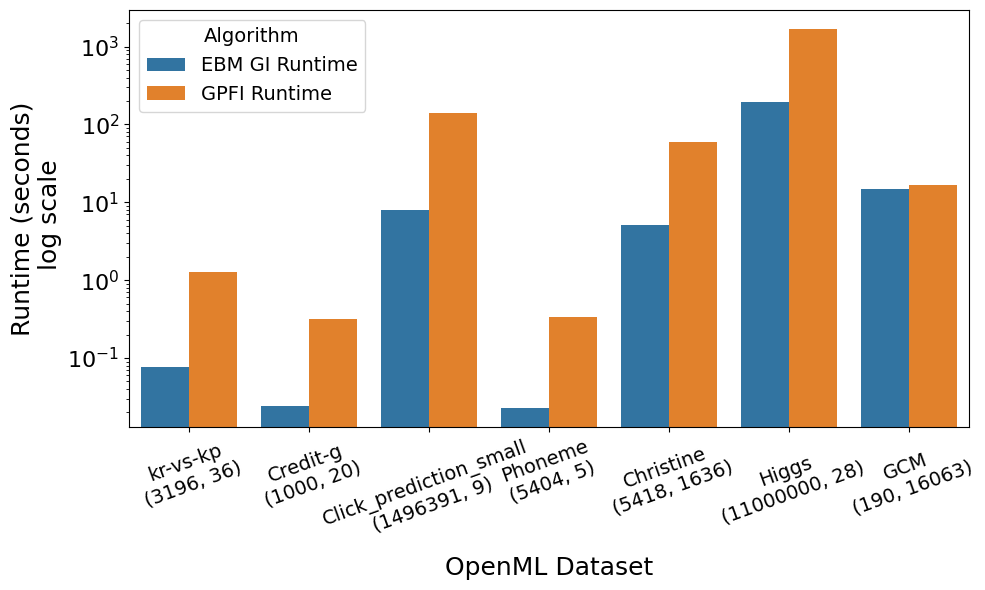

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape the DataFrame to long format for plotting
melted_df = runtime_df.melt(id_vars=['Dataset'], var_name='Algorithm', value_name='Runtime')

# Plotting
plt.figure(figsize=(10, 6))
bar_plot = sns.barplot(x='Dataset', y='Runtime', hue='Algorithm', data=melted_df)
# plt.title('Comparison of Algorithm Runtimes for Each Dataset', fontsize=20)
plt.ylabel('Runtime (seconds)\n log scale', fontsize=18)
plt.xlabel('OpenML Dataset', fontsize=18)
plt.legend(title='Algorithm', title_fontsize='14', fontsize='14')
plt.tick_params(axis='x', rotation=20, labelsize=14)  # Set tick size for both x and y axes
plt.tick_params(axis='y', labelsize=16)  # Set tick size for both x and y axes
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.tight_layout()  # Adjust subplots to give some padding and prevent overlap
plt.show()
